# SARIMAXによる株価予測（日本郵政）

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

In [2]:
data = pd.read_csv('./9101_jp_m.csv', index_col='Date', parse_dates=True)
data.drop('Volume', axis=1, inplace=True)
data.index = pd.DatetimeIndex(data.index.values, freq=data.index.inferred_freq)
data

,Open,High,Low,Close
2018-01-31,735.619,794.629,710.445,716.213
2018-02-28,719.888,720.672,592.170,611.574
2018-03-31,603.449,604.230,527.656,568.766
2018-04-30,567.180,646.084,540.967,618.022
2018-05-31,614.844,660.117,573.797,587.569
...,...,...,...,...
2022-09-30,3139.740,3142.700,2422.000,2467.000
2022-10-31,2429.000,2873.000,2422.000,2699.000
2022-11-30,2701.000,3041.000,2502.000,3037.000
2022-12-31,3084.000,3275.000,2969.000,3110.000


In [3]:
data.tail(20)

,Open,High,Low,Close
2021-06-30,1244.99,1606.44,1238.07,1559.36
2021-07-31,1551.05,1639.68,1409.79,1628.60
2021-08-31,1708.92,2462.29,1675.68,2456.75
2021-09-30,2459.52,3129.79,2329.11,2365.50
2021-10-31,2281.52,2449.48,1959.59,2289.92
2021-11-30,2351.50,2502.67,2001.58,2071.56
2021-12-31,2110.76,2488.68,2068.77,2452.28
2022-01-31,2471.88,2765.82,2231.13,2491.48
2022-02-28,2575.46,2989.77,2463.48,2986.97
2022-03-31,3068.15,3496.46,2811.27,3184.13


## データの可視化

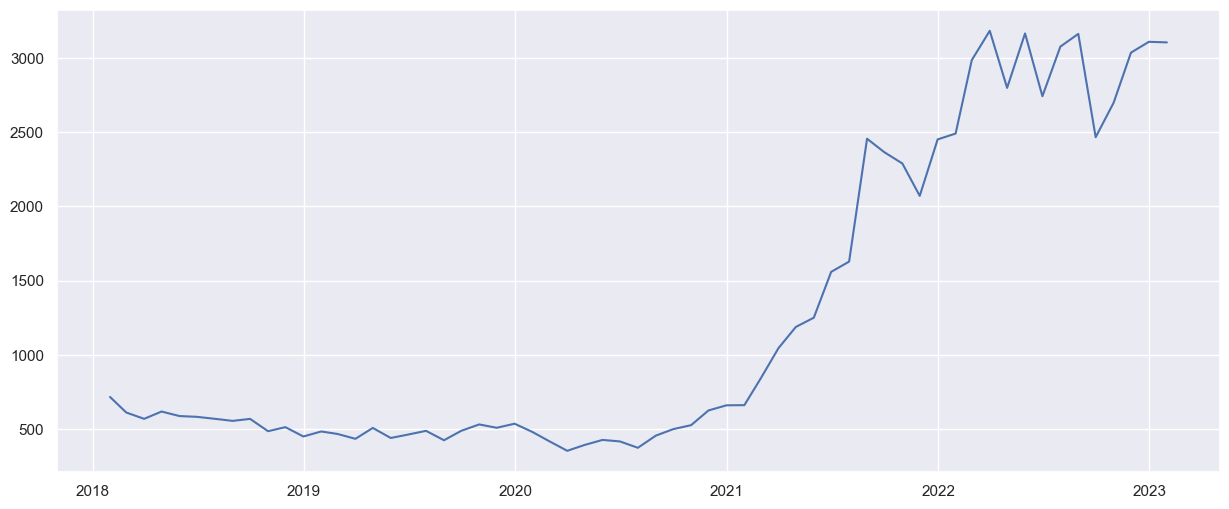

In [4]:
plt.plot(data['Close'])
plt.show()

## 自己相関係数・偏自己相関係数

c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


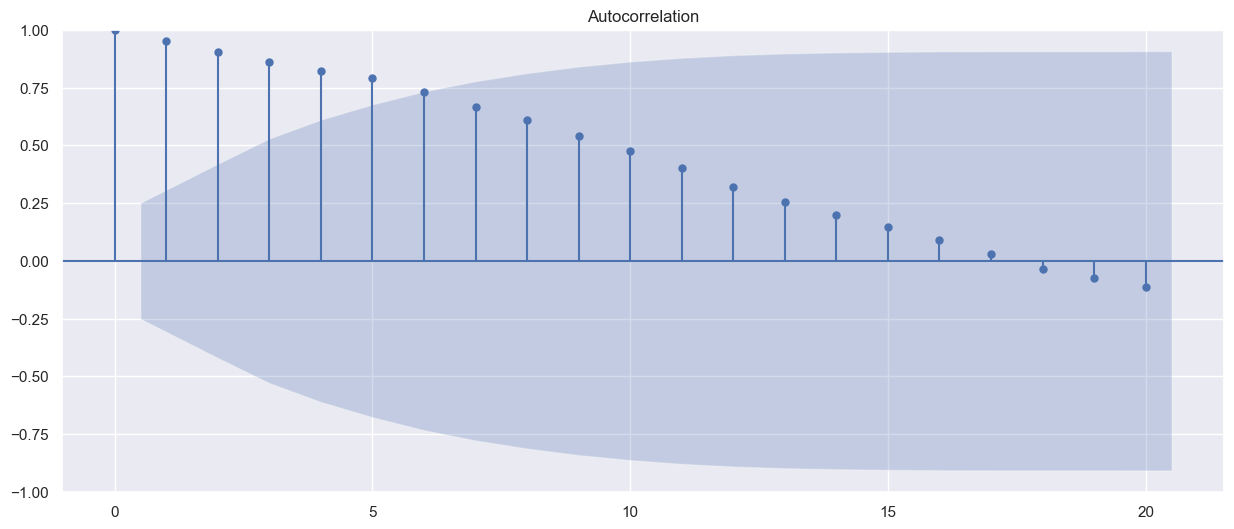

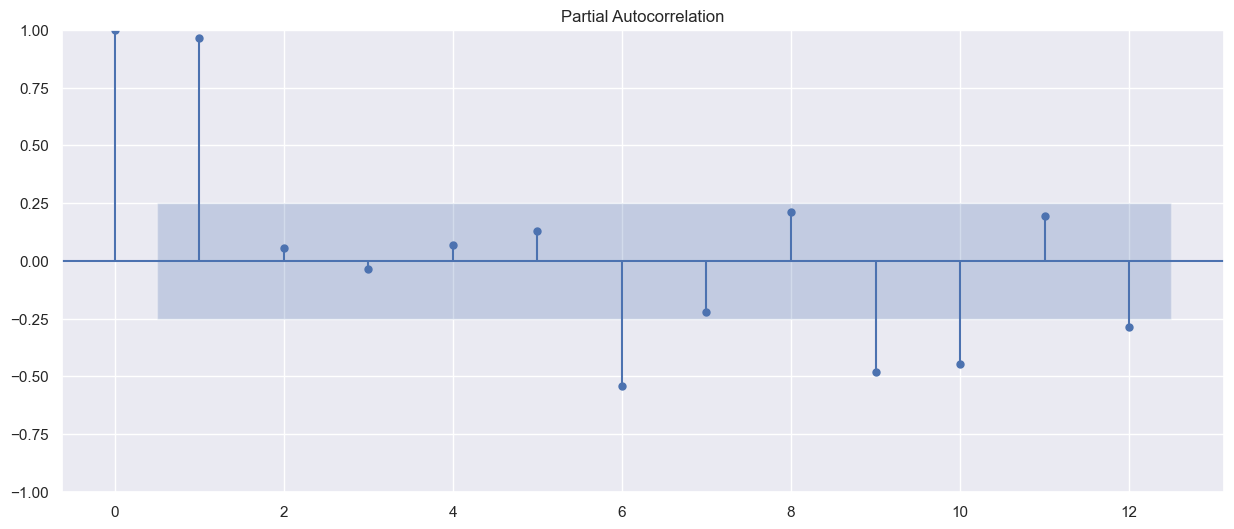

In [5]:
fig_1 = sm.graphics.tsa.plot_acf(data['Close'], lags=20)
fig_2 = sm.graphics.tsa.plot_pacf(data['Close'], lags=12)

## 波状分解

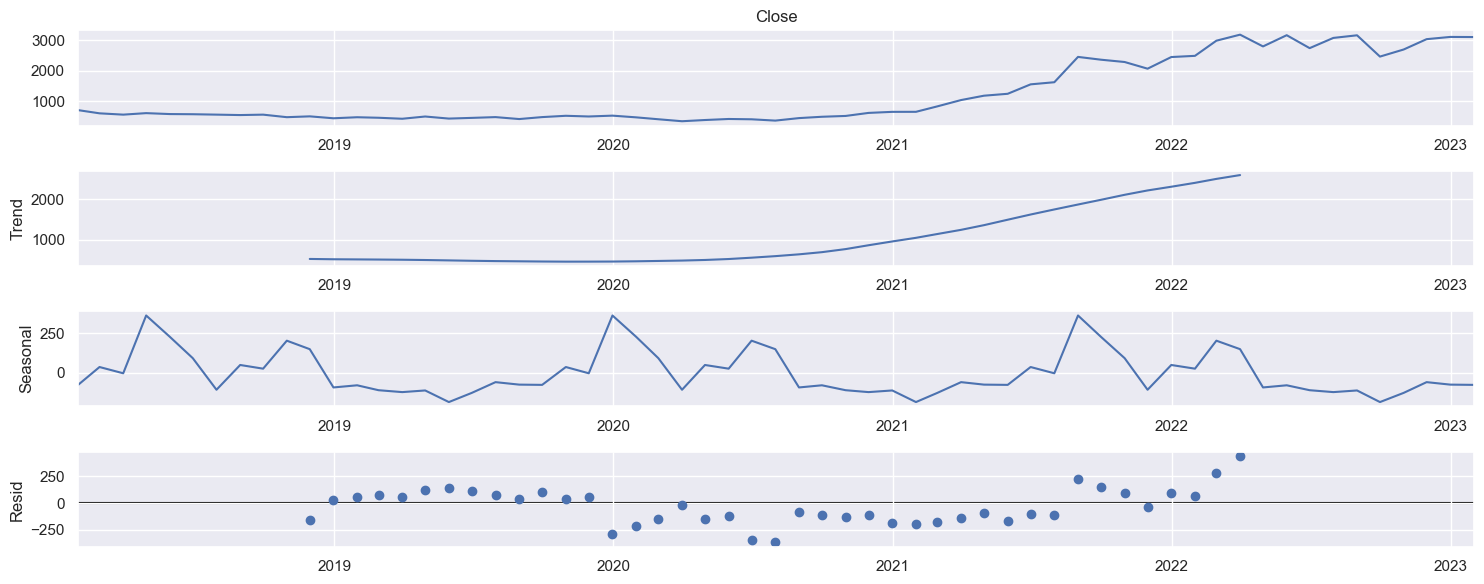

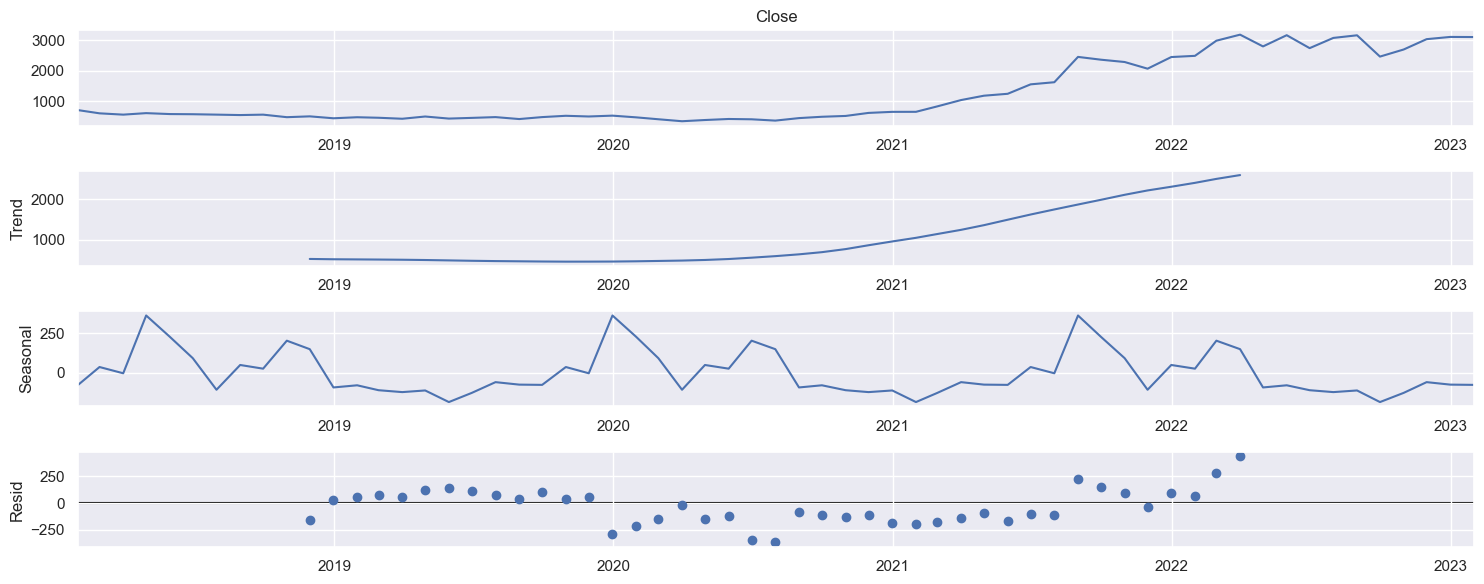

In [6]:
result = seasonal_decompose(data['Close'], period=20, two_sided=True)
result.plot()

## 単位根検定

In [7]:
print('-----------原系列-----------')
nc = sm.tsa.stattools.adfuller(data['Close'], regression='n')
c = sm.tsa.stattools.adfuller(data['Close'], regression='c')
ct = sm.tsa.stattools.adfuller(data['Close'], regression='ct')
ctt = sm.tsa.stattools.adfuller(data['Close'], regression='ctt')

print('nc p-value:' + str(nc[1]))
print('c p-value:' + str(c[1]))
print('ct p-value:' + str(ct[1]))
print('ctt p-value:' + str(ctt[1]))

print()
print('--------一次階差系列---------')
data_diff = data['Close'].diff().dropna()

nc = sm.tsa.stattools.adfuller(data_diff, regression='nc')
c = sm.tsa.stattools.adfuller(data_diff, regression='c')
ct = sm.tsa.stattools.adfuller(data_diff, regression='ct')
ctt = sm.tsa.stattools.adfuller(data_diff, regression='ctt')

print('nc p-value:' + str(nc[1]))
print('c p-value:' + str(c[1]))
print('ct p-value:' + str(ct[1]))
print('ctt p-value:' + str(ctt[1]))

-----------原系列-----------
nc p-value:0.9810860081344576
c p-value:0.9861031571829602
ct p-value:0.7941159723483964
ctt p-value:0.05375628346989002

--------一次階差系列---------
nc p-value:1.7789183824570387e-15
c p-value:8.020982455241304e-16
ct p-value:1.2282064130032471e-14
ctt p-value:2.5181289346775783e-14


c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


原系列はやはり単位根が存在している。\
一方一次の階差をとった系列はp値が小さいため、共分散定常性を持つことを仮定できる。

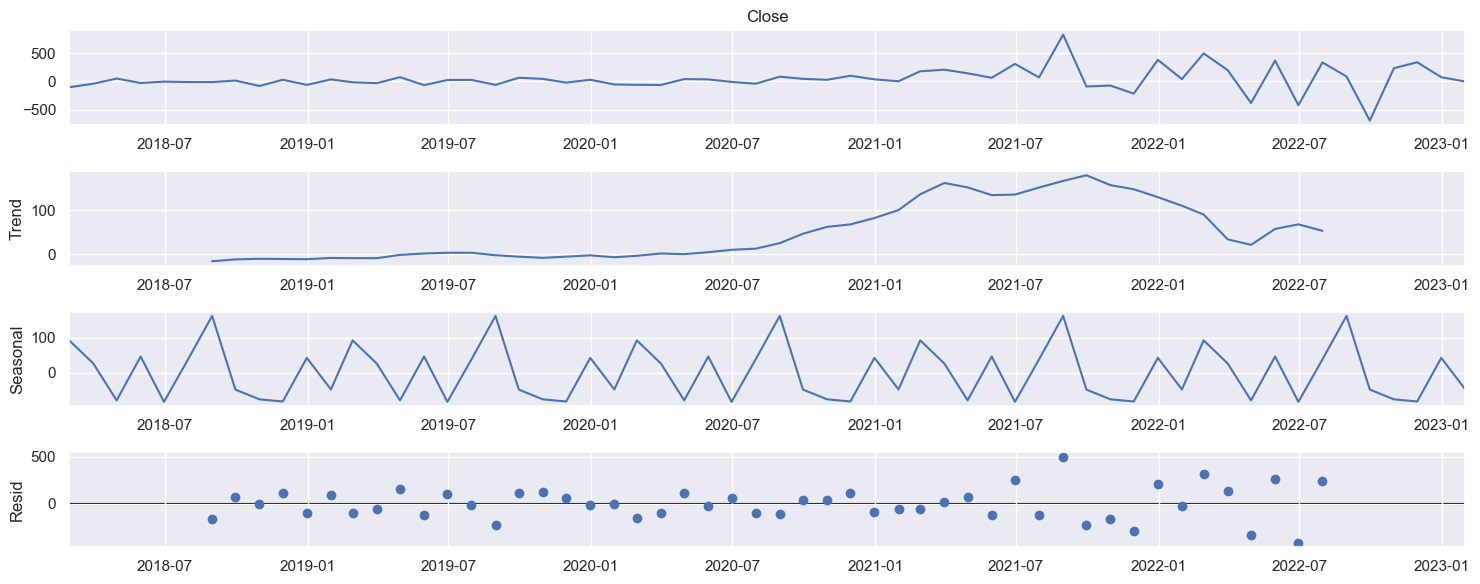

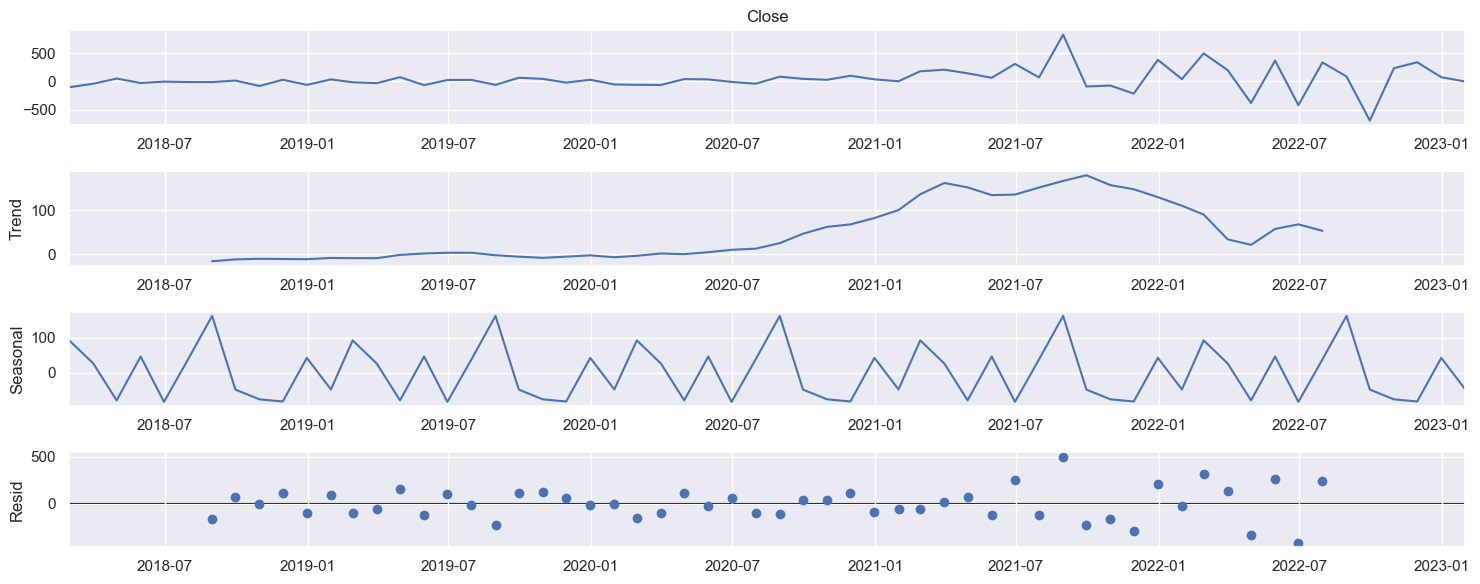

In [8]:
# 一次階差系列をプロットしてみる
result_diff = seasonal_decompose(data_diff, period=12, two_sided=True)
result_diff.plot()

In [9]:
#まずはARMAモデルにて最適な次数を探索
params2 = sm.tsa.arma_order_select_ic(data_diff, ic='aic')
params2

c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'aic':             0           1           2
 0  815.116588  814.550210  816.449980
 1  814.497251  816.477447  816.799126
 2  816.466961  817.470419  819.218314
 3  818.260270  819.266293  820.387187
 4  819.995575  821.179507  822.356705,
 'aic_min_order': (1, 0)}

In [44]:
#訓練データと検証データに分割
train_data = data[:"2021-12-31"]
test_data = data["2022-01-01":]

In [97]:
def selectparameter(DATA, s):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]
    parameters = []
    AICs = np.array([])
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(DATA, order=param, seasonal_order=param_seasonal)
                results = mod.fit()
                parameters.append([param, param_seasonal, results.aic])
                AICs = np.append(AICs, results.aic)
            except:
                print('error')
                continue
    return parameters[np.argmin(AICs)]
best_params = selectparameter(data['Close'], 12)
print('BEST PARAMETER:', best_params)

c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\ayumi\anaconda3\lib\site-pack

BEST PARAMETER: [(0, 1, 0), (1, 1, 0, 12), 673.4505304575428]


In [98]:
sarima_model = sm.tsa.SARIMAX(train_data['Close'], order=best_params[0], seasonal_order=best_params[1], enforce_invertibility=False, enforce_stationarity=False)
result = sarima_model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -156.791
Date:                            Thu, 19 Jan 2023   AIC                            317.582
Time:                                    21:33:22   BIC                            319.853
Sample:                                01-31-2018   HQIC                           318.153
                                     - 12-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0458      0.743      0.062      0.951      -1.411       1.502
sigma2      4.883e+04   1.57e+04      3.102      0.002     1.8e+04    7.97e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                11.67
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):              20.96   Skew:                             1.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [99]:
best_pred = result.predict(start='2021-01', end='2023-12')

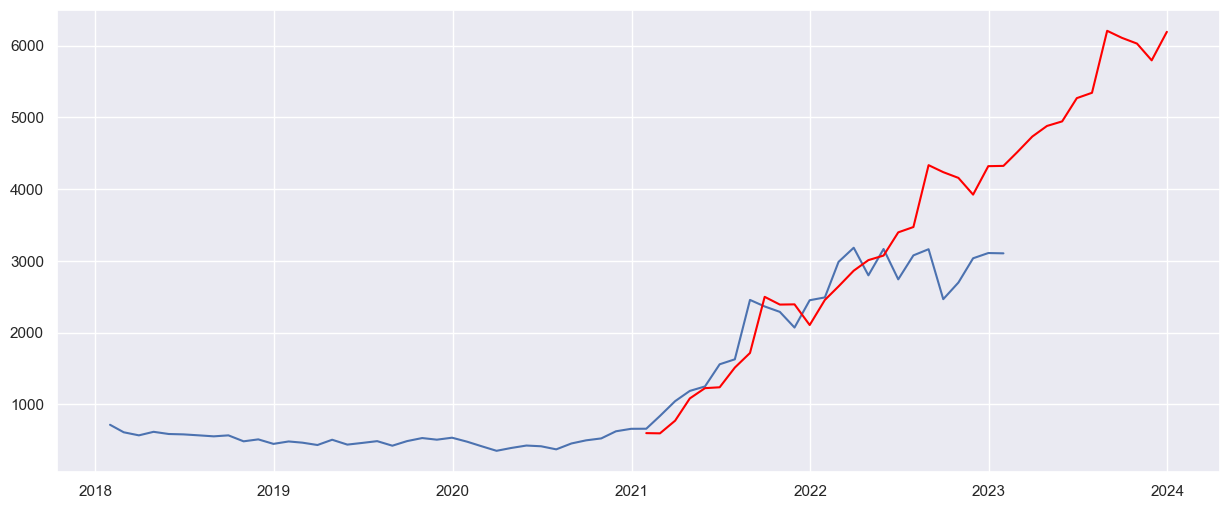

In [100]:
plt.plot(data['Close'], c='b')
plt.plot(best_pred, c='red')
plt.show()